In [141]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks # Import find_peaks

# --- Parameters to Adjust ---
IMAGE_PATH = 'zurg.jpg' # Make sure this points to your Mongolian script image

# Morphological Opening Parameters (Keep from previous step if needed, but likely less critical now)
# OPEN_KERNEL_HEIGHT = 3
# OPEN_KERNEL_WIDTH = 1

# Parameters for find_peaks (Valleys in profile) - ** TUNE THESE **
# distance: Minimum horizontal distance (pixels) between detected valleys.
#           Adjust based on typical minimum word spacing in your images.
MIN_VALLEY_DISTANCE = 6 # Start with a small value, increase if it splits words too much

# prominence: Minimum vertical depth of a valley relative to its neighboring peaks.
#             This is often the MOST IMPORTANT parameter.
#             Look at the Y-axis scale of the *INVERTED* profile plot (peaks).
#             How high do the peaks corresponding to REAL gaps rise above their local base?
#             Try values like 0.5, 1, 2, 5, 10... depending on the profile scale and noise.
MIN_VALLEY_PROMINENCE = 20.0 # Start relatively low and increase if needed

# height: Optional: Can specify a minimum height for the inverted peak
#         (minimum depth from the max projection value for the original valley)
# MIN_INVERTED_PEAK_HEIGHT = None # e.g., 2 means valley must be at least 2 units below max projection

# width: Optional: Minimum width of the valley (peak in inverted profile)
# MIN_VALLEY_WIDTH = None

# Minimum width for a character sequence to be considered a word
MIN_WORD_WIDTH = 11 # Adjust based on the shortest expected word/character block

# Padding around cropped words
PADDING = 3
# --- End Parameters ---

# Verify Scipy Installation
try:
    import scipy
    print(f"Scipy version {scipy.__version__} found.")
except ImportError:
    print("ERROR: Scipy library not found. Please install it (e.g., 'pip install scipy')")
    exit() # Stop execution if scipy isn't available

print("\n--- Parameters ---")
print(f"IMAGE_PATH: {IMAGE_PATH}")
print(f"MIN_VALLEY_DISTANCE: {MIN_VALLEY_DISTANCE}")
print(f"MIN_VALLEY_PROMINENCE: {MIN_VALLEY_PROMINENCE}")
# print(f"MIN_INVERTED_PEAK_HEIGHT: {MIN_INVERTED_PEAK_HEIGHT}") # Uncomment if using height
# print(f"MIN_VALLEY_WIDTH: {MIN_VALLEY_WIDTH}") # Uncomment if using width
print(f"MIN_WORD_WIDTH: {MIN_WORD_WIDTH}")
print(f"PADDING: {PADDING}")
print("\nParameters set. Proceed to the next cell to load the image.")

# Initialize variables for later cells
img = None
img_rgb = None
gray = None
binary_img = None
vertical_projection = None
valleys = None
final_boundaries = []
cropped_words_rgb = []


Scipy version 1.15.2 found.

--- Parameters ---
IMAGE_PATH: zurg.jpg
MIN_VALLEY_DISTANCE: 6
MIN_VALLEY_PROMINENCE: 20.0
MIN_WORD_WIDTH: 11
PADDING: 3

Parameters set. Proceed to the next cell to load the image.


Image loaded successfully.
Binarized Image (Text should be white):


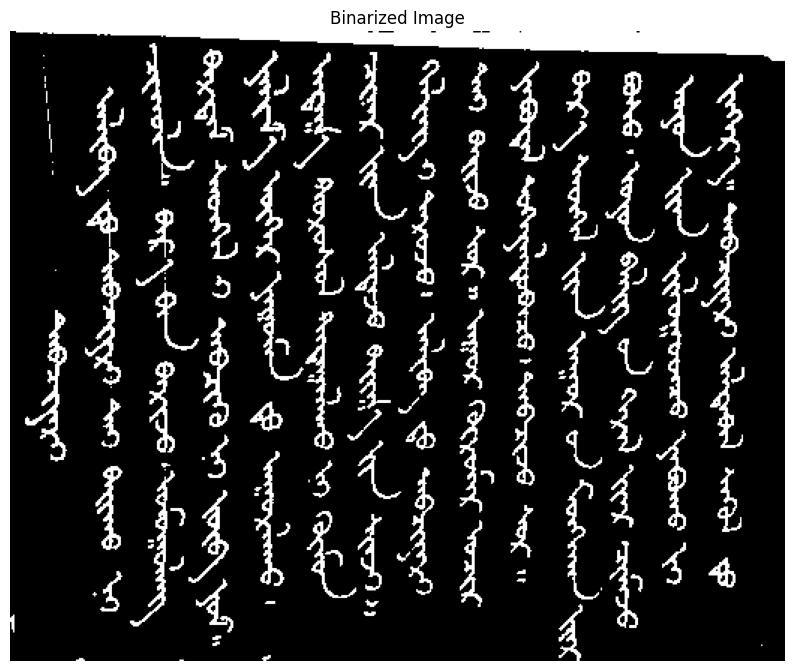

In [142]:
# Load image
img = cv2.imread(IMAGE_PATH)
if img is None:
    print(f"Error: Could not load image at {IMAGE_PATH}")
    # In Jupyter, you might want to stop or handle differently
    # raise FileNotFoundError(f"Could not load image at {IMAGE_PATH}")
else:
    print("Image loaded successfully.")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For displaying original later
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binarization (Otsu should still work well)
    # Text white (255), background black (0)
    thresh_val, binary_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    print("Binarized Image (Text should be white):")
    plt.figure(figsize=(10, 10)) # Adjust figsize if needed
    plt.imshow(binary_img, cmap='gray')
    plt.title('Binarized Image')
    plt.axis('off') # Hide axes ticks
    plt.show()

    # --- Optional: Apply Morphological Opening (if still needed for noise) ---
    # If you found opening helpful before, you can apply it here to binary_img
    # open_kernel = np.ones((OPEN_KERNEL_HEIGHT, OPEN_KERNEL_WIDTH), np.uint8)
    # binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, open_kernel)
    # print("Applied Morphological Opening (Optional)")
    # plt.figure(figsize=(10,10))
    # plt.imshow(binary_img, cmap='gray')
    # plt.title('Binary Image After Opening (Optional)')
    # plt.axis('off')
    # plt.show()
    # --- End Optional Opening ---

Calculated vertical projection profile.
Found 13 potential valleys using find_peaks.

--- ACTION REQUIRED ---
Examine the plots above, especially the *Inverted Profile*.
Red markers show the detected valleys/peaks.
  - Are the markers placed correctly at the gaps BETWEEN words?
  - Are markers missing from real gaps? -> DECREASE 'MIN_VALLEY_PROMINENCE' (or distance).
  - Are markers appearing inside words (small dips)? -> INCREASE 'MIN_VALLEY_PROMINENCE' (or distance).
The 'prominence' value (orange lines, if shown) is key.
--> Go back to Cell 1, adjust parameters (mainly MIN_VALLEY_PROMINENCE), and re-run Cell 1 and this cell.


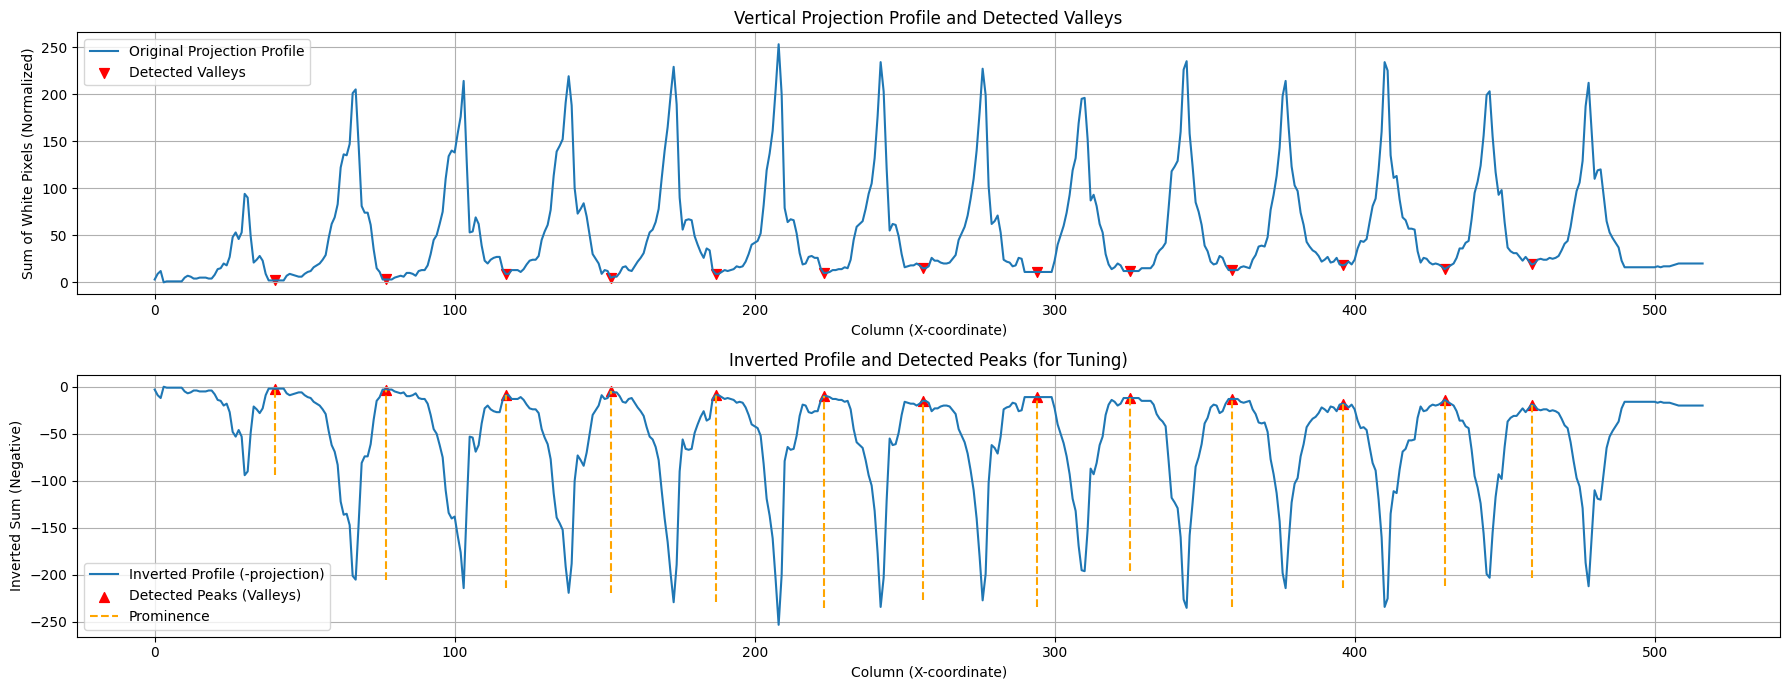

In [143]:
if img is not None and binary_img is not None:
    # Calculate Vertical Projection Profile
    # Sum pixel values along vertical columns (axis=0)
    # Normalize sum by dividing by 255 (max pixel value)
    vertical_projection = np.sum(binary_img, axis=0) / 255
    print("Calculated vertical projection profile.")

    # --- Find Valleys using find_peaks ---
    # Invert the profile: peaks in inverted profile correspond to valleys in original
    # Using simple negation might be sensitive to the absolute scale.
    # Using max() - profile makes heights more relative. Choose one.
    # inverted_projection = np.max(vertical_projection) - vertical_projection
    inverted_projection = -vertical_projection # Simpler inversion

    # Find peaks in the inverted profile (valleys in the original)
    # Pass parameters defined in Cell 1
    valleys, properties = find_peaks(
        inverted_projection,
        distance=MIN_VALLEY_DISTANCE,
        prominence=MIN_VALLEY_PROMINENCE
        # height=MIN_INVERTED_PEAK_HEIGHT, # Uncomment if using height
        # width=MIN_VALLEY_WIDTH       # Uncomment if using width
    )
    print(f"Found {len(valleys)} potential valleys using find_peaks.")
    # valleys now contains the x-coordinates of the detected valleys (centers of spaces)

    # --- Plot the Profile and Detected Valleys ---
    plt.figure(figsize=(18, 7)) # Wider figure

    # Plot Original Profile
    plt.subplot(2, 1, 1) # 2 rows, 1 column, first plot
    plt.plot(vertical_projection, label='Original Projection Profile')
    plt.scatter(valleys, vertical_projection[valleys], color='red', marker='v', s=50, label='Detected Valleys')
    plt.title('Vertical Projection Profile and Detected Valleys')
    plt.xlabel('Column (X-coordinate)')
    plt.ylabel('Sum of White Pixels (Normalized)')
    plt.legend()
    plt.grid(True)

    # Plot Inverted Profile and Detected Peaks
    plt.subplot(2, 1, 2) # 2 rows, 1 column, second plot
    plt.plot(inverted_projection, label='Inverted Profile (-projection)')
    plt.scatter(valleys, inverted_projection[valleys], color='red', marker='^', s=50, label='Detected Peaks (Valleys)')
    # Optional: Plot prominence lines (useful for tuning)
    if 'prominences' in properties:
      plt.vlines(x=valleys, ymin=inverted_projection[valleys] - properties['prominences'],
                 ymax=inverted_projection[valleys], color='orange', linestyle='--', label='Prominence')

    # Optional: Plot height threshold line if using height parameter
    # if MIN_INVERTED_PEAK_HEIGHT is not None:
    #     plt.axhline(y=MIN_INVERTED_PEAK_HEIGHT, color='purple', linestyle=':', label=f'Min Height ({MIN_INVERTED_PEAK_HEIGHT})')


    plt.title('Inverted Profile and Detected Peaks (for Tuning)')
    plt.xlabel('Column (X-coordinate)')
    plt.ylabel('Inverted Sum (Negative)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Adjust spacing

    print(f"\n--- ACTION REQUIRED ---")
    print(f"Examine the plots above, especially the *Inverted Profile*.")
    print(f"Red markers show the detected valleys/peaks.")
    print(f"  - Are the markers placed correctly at the gaps BETWEEN words?")
    print(f"  - Are markers missing from real gaps? -> DECREASE 'MIN_VALLEY_PROMINENCE' (or distance).")
    print(f"  - Are markers appearing inside words (small dips)? -> INCREASE 'MIN_VALLEY_PROMINENCE' (or distance).")
    print(f"The 'prominence' value (orange lines, if shown) is key.")
    print(f"--> Go back to Cell 1, adjust parameters (mainly MIN_VALLEY_PROMINENCE), and re-run Cell 1 and this cell.")
    plt.show()

else:
    print("Skipping profile calculation/valley finding because image or binary image is not available.")

Defining boundaries based on 13 detected valleys...

Found 14 potential word boundaries using find_peaks.
Drawing separation lines...
Showing image with detected separation lines (green) at valley locations:


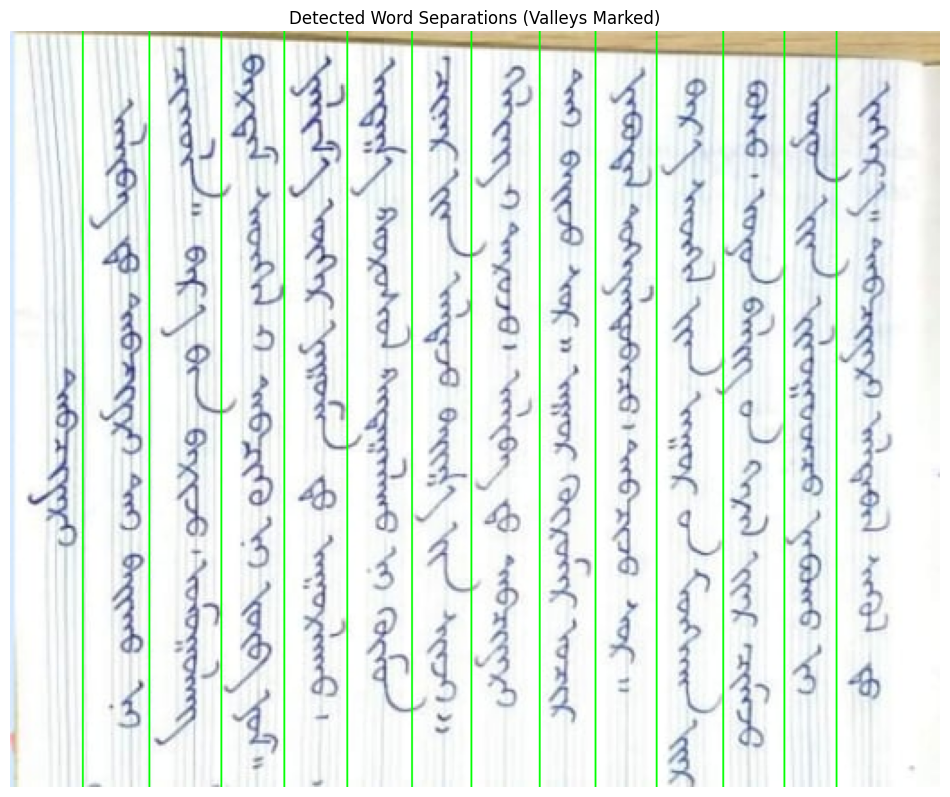

In [144]:
if img is not None and valleys is not None:
    # --- Define Word Boundaries Based on Valley Locations ---
    word_boundaries = []
    start_x = 0
    img_width = binary_img.shape[1]

    print(f"Defining boundaries based on {len(valleys)} detected valleys...")

    # Iterate through the detected valley locations (which are the gaps)
    for i, valley_x in enumerate(valleys):
        end_x = valley_x # The space starts around here

        # Check if the segment before this valley is wide enough to be a word
        if end_x - start_x >= MIN_WORD_WIDTH:
            word_boundaries.append({'start': start_x, 'end': end_x})
            # print(f"  Added word: ({start_x}, {end_x}), Width: {end_x - start_x}") # Debug print

        # The next word starts after this valley
        start_x = valley_x

    # Handle the last word (from the last valley to the end of the image)
    end_x = img_width
    if end_x - start_x >= MIN_WORD_WIDTH:
         word_boundaries.append({'start': start_x, 'end': end_x})
         # print(f"  Added last word: ({start_x}, {end_x}), Width: {end_x - start_x}") # Debug print


    # Final list of (start, end) tuples
    final_boundaries = [(b['start'], b['end']) for b in word_boundaries]
    print(f"\nFound {len(final_boundaries)} potential word boundaries using find_peaks.")
    # print(f"Boundaries: {final_boundaries}") # Debug print

    # --- Visualize Separation Lines ---
    img_copy_for_drawing = img.copy() # Use the original color image BGR format
    line_color_bgr = (0, 255, 0) # Green in BGR
    line_thickness = 1

    if not final_boundaries:
         print("No word boundaries found to draw.")
    else:
        print("Drawing separation lines...")
        # Draw lines AT the detected valley locations (the gaps)
        # We can draw at the start/end derived, or directly at valleys
        for valley_x in valleys:
            cv2.line(img_copy_for_drawing, (valley_x, 0), (valley_x, img.shape[0]), line_color_bgr, line_thickness)

        # Display the image with lines using Matplotlib
        print("Showing image with detected separation lines (green) at valley locations:")
        plt.figure(figsize=(12, 10))
        plt.imshow(cv2.cvtColor(img_copy_for_drawing, cv2.COLOR_BGR2RGB))
        plt.title('Detected Word Separations (Valleys Marked)')
        plt.axis('off')
        plt.show()

elif img is not None:
     print("Valleys were not detected. Cannot identify boundaries.")
else:
    print("Skipping boundary identification because image failed to load.")

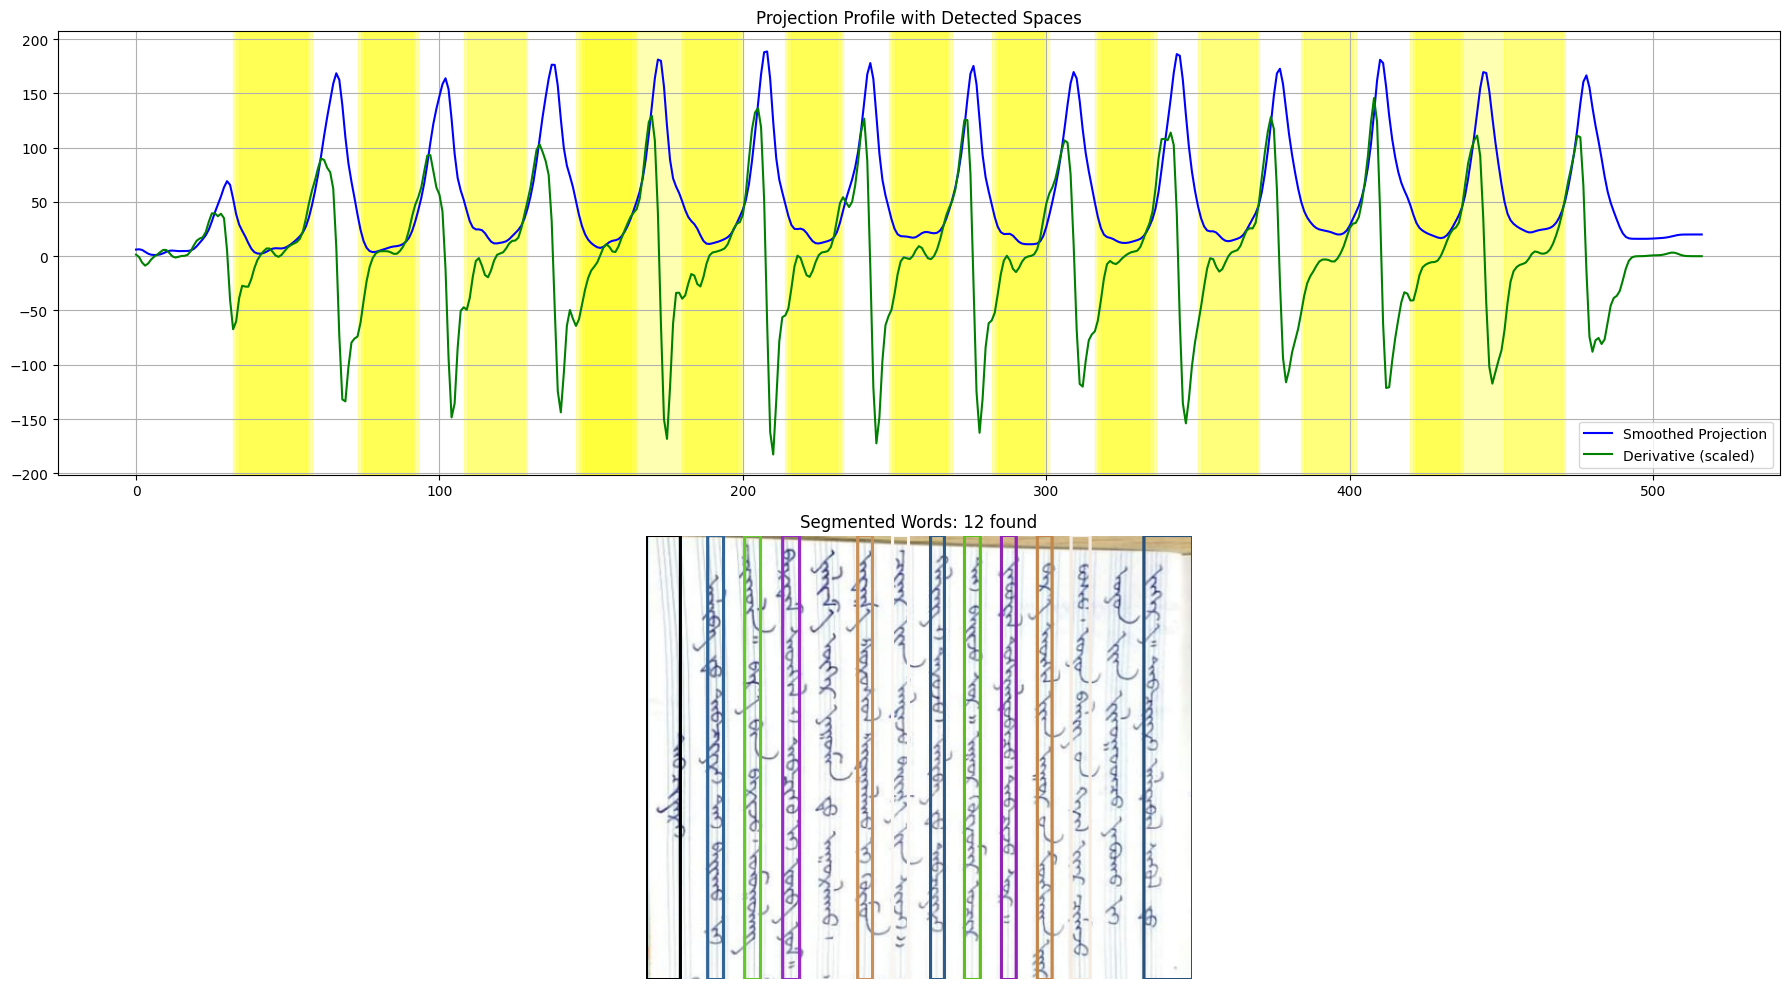

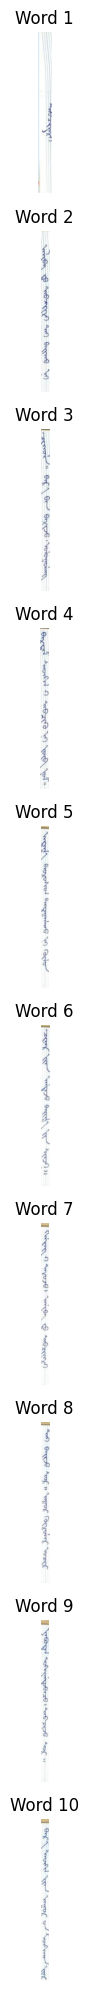

In [5]:
if img is not None and binary_img is not None:
    # Calculate Vertical Projection Profile with smoothing
    vertical_projection = np.sum(binary_img, axis=0) / 255
    
    # Apply a small amount of smoothing to reduce noise in the profile
    from scipy.ndimage import gaussian_filter1d
    smoothed_projection = gaussian_filter1d(vertical_projection, sigma=1.5)
    
    # Use the derivative to find transition points
    # Negative derivative indicates transition from text to space
    # Positive derivative indicates transition from space to text
    derivative = np.gradient(smoothed_projection)
    
    # Find space starts (text-to-space transitions) and space ends (space-to-text transitions)
    space_starts = []
    space_ends = []
    
    # Use threshold for derivative to find significant transitions
    neg_threshold = -MIN_VALLEY_PROMINENCE/3  # Adjust based on your image characteristics
    pos_threshold = MIN_VALLEY_PROMINENCE/3   # Adjust based on your image characteristics
    
    for i in range(1, len(derivative) - 1):
        # Significant negative derivative (text to space transition)
        if derivative[i] < neg_threshold and smoothed_projection[i] < np.mean(smoothed_projection):
            space_starts.append(i)
        # Significant positive derivative (space to text transition)
        elif derivative[i] > pos_threshold and smoothed_projection[i] < np.mean(smoothed_projection):
            space_ends.append(i)
    
    # Pair up starts and ends to define spaces
    spaces = []
    i_start = 0
    i_end = 0
    
    while i_start < len(space_starts) and i_end < len(space_ends):
        start = space_starts[i_start]
        # Find the next end that comes after this start
        while i_end < len(space_ends) and space_ends[i_end] <= start:
            i_end += 1
        
        if i_end < len(space_ends):
            end = space_ends[i_end]
            # Only add if the space is reasonably sized
            space_width = end - start
            if 3 <= space_width <= 50:  # Adjust min/max space width as needed
                spaces.append((start, end))
            i_end += 1
        i_start += 1
    
    # Define word boundaries based on spaces
    word_boundaries = []
    current_start = 0
    
    for space_start, space_end in spaces:
        # Word ends at the beginning of the space
        word_end = space_start
        if word_end - current_start >= MIN_WORD_WIDTH:
            word_boundaries.append((current_start, word_end))
        # Next word starts at the end of the space
        current_start = space_end
    
    # Handle the last word
    if binary_img.shape[1] - current_start >= MIN_WORD_WIDTH:
        word_boundaries.append((current_start, binary_img.shape[1]))
    
    # Visualize both profile and segmentation
    plt.figure(figsize=(18, 10))
    
    # Plot the projection profile
    plt.subplot(2, 1, 1)
    plt.plot(smoothed_projection, 'b-', label='Smoothed Projection')
    plt.plot(derivative * 5, 'g-', label='Derivative (scaled)') # Scale for visibility
    
    # Mark the spaces
    for space_start, space_end in spaces:
        plt.axvspan(space_start, space_end, color='yellow', alpha=0.3)
    
    plt.title('Projection Profile with Detected Spaces')
    plt.legend()
    plt.grid(True)
    
    # Show the image with word boundaries
    plt.subplot(2, 1, 2)
    img_with_boundaries = img_rgb.copy()
    
    # Draw word boundaries in different colors
    for i, (start, end) in enumerate(word_boundaries):
        # Display each word in a different color rectangle
        color = [(i*50)%255, (i*100)%255, (i*150)%255]  # Generate varied colors
        cv2.rectangle(img_with_boundaries, (start, 0), (end, img_rgb.shape[0]), color, 2)
    
    plt.imshow(img_with_boundaries)
    plt.title(f'Segmented Words: {len(word_boundaries)} found')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Optional: Extract individual words to verify segmentation
    cropped_words = []
    for i, (start, end) in enumerate(word_boundaries):
        # Add padding but prevent out-of-bounds
        pad_start = max(0, start - PADDING)
        pad_end = min(img_rgb.shape[1], end + PADDING)
        
        word_img = img_rgb[:, pad_start:pad_end, :]
        cropped_words.append(word_img)
    
    # Display first few words (if any)
    if cropped_words:
        num_to_show = min(10, len(cropped_words))
        plt.figure(figsize=(15, 2 * num_to_show))
        for i in range(num_to_show):
            plt.subplot(num_to_show, 1, i+1)
            plt.imshow(cropped_words[i])
            plt.title(f'Word {i+1}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

Processing image with dimensions: 517x420
Found 14 whitespace separators
Identified 13 potential words


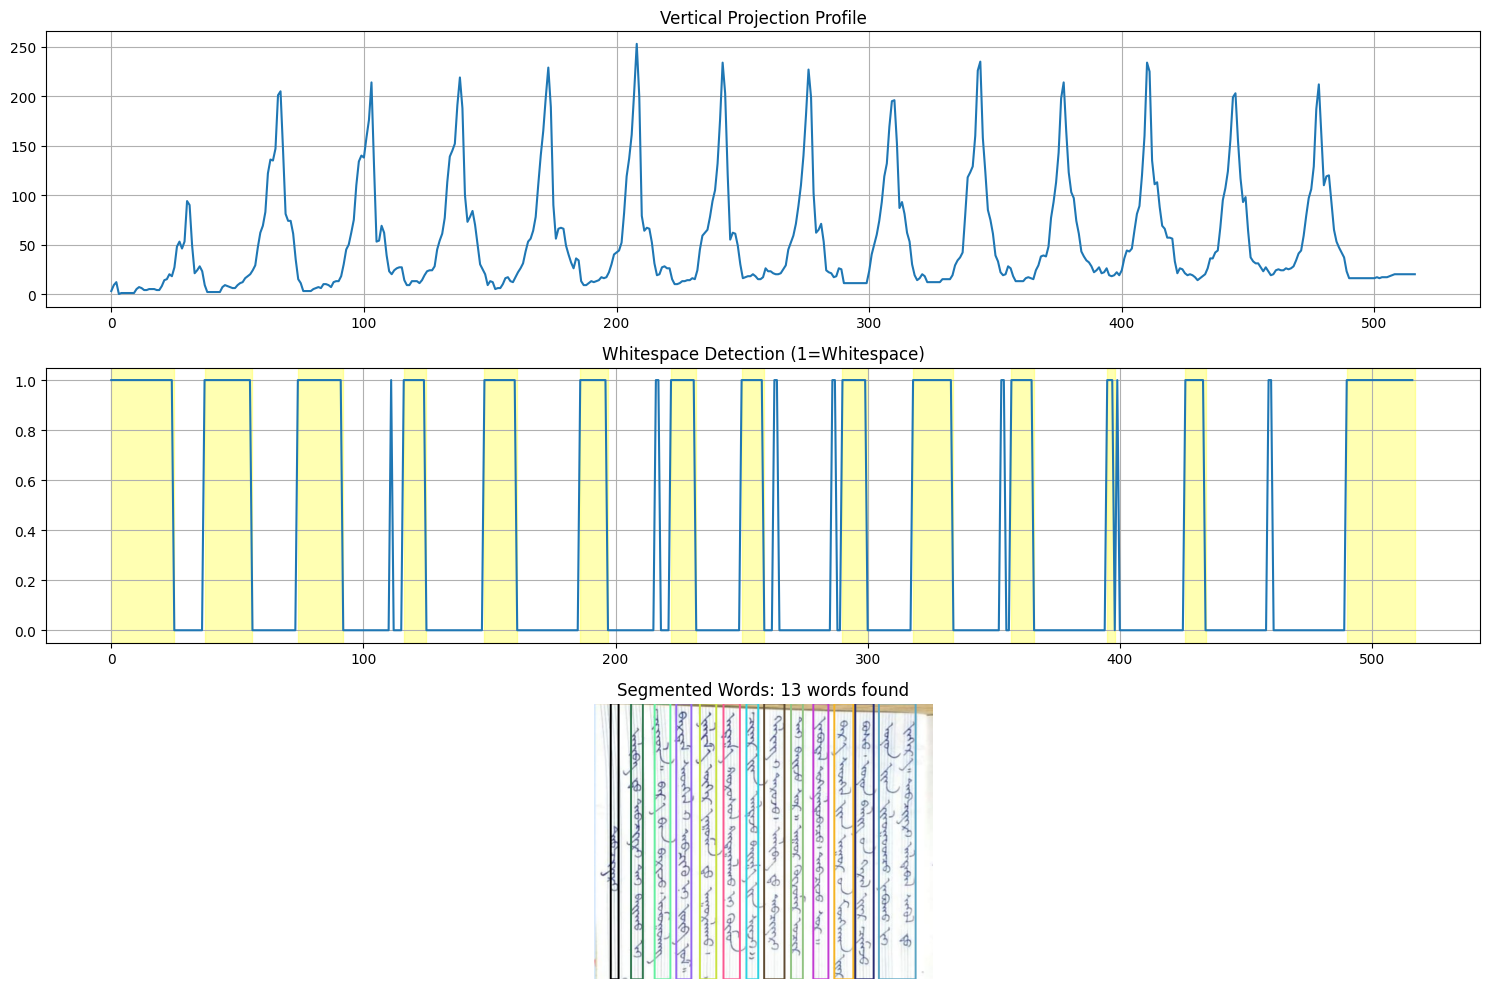

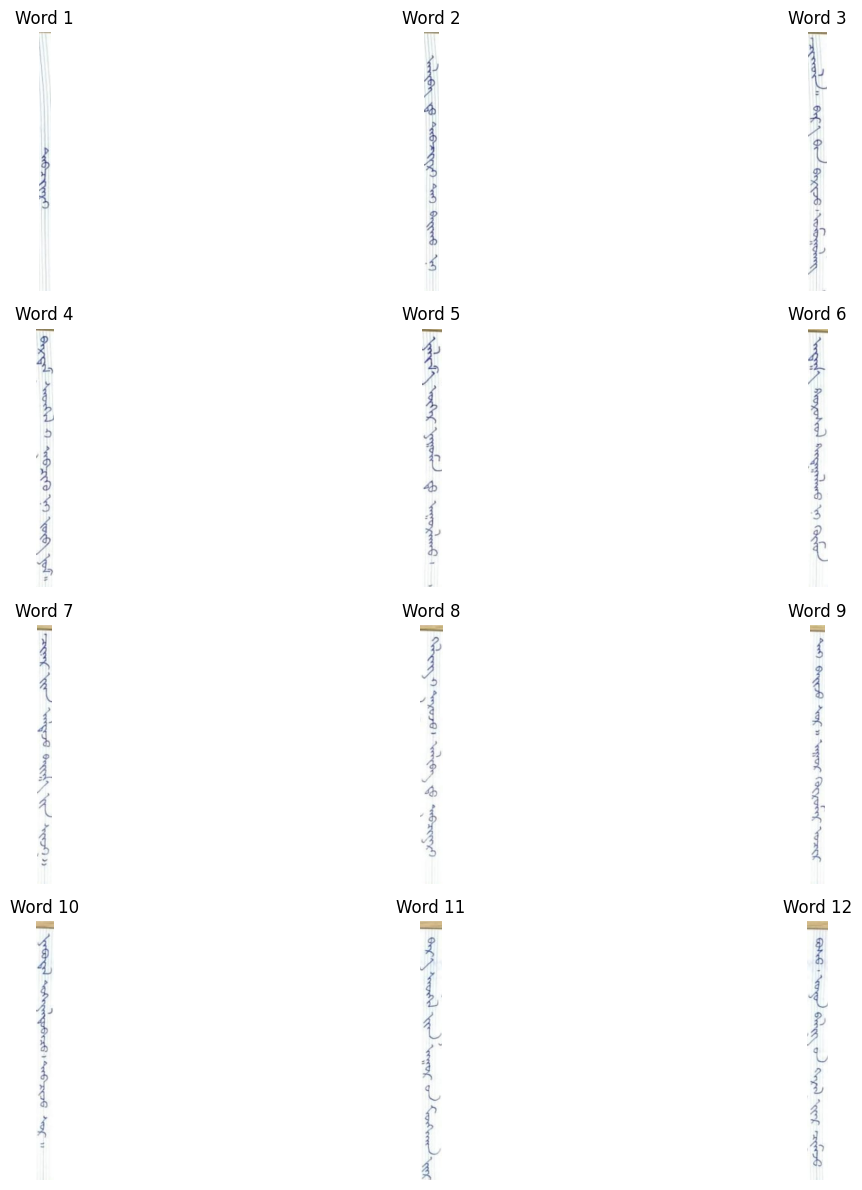

Extracted 13 words.
You can access all extracted words in the variable 'cropped_words_rgb'


In [19]:
if img is not None and binary_img is not None:
    # Get image dimensions
    height, width = binary_img.shape
    print(f"Processing image with dimensions: {width}x{height}")
    
    # Calculate Vertical Projection Profile
    vertical_projection = np.sum(binary_img, axis=0) / 255
    
    # --- More robust word separation ---
    # 1. Find zero regions (complete vertical whitespace)
    # Identify columns with no black pixels or very few (threshold for noise)
    whitespace_threshold = height * 0.05  # Consider columns with <5% black pixels as whitespace
    is_whitespace = vertical_projection < whitespace_threshold
    
    # 2. Find continuous whitespace regions (word separators)
    word_separators = []
    in_whitespace = False
    whitespace_start = 0
    
    for x in range(width):
        if is_whitespace[x] and not in_whitespace:
            # Start of a whitespace region
            whitespace_start = x
            in_whitespace = True
        elif not is_whitespace[x] and in_whitespace:
            # End of a whitespace region
            whitespace_end = x
            # Only consider whitespace regions wider than threshold
            if whitespace_end - whitespace_start >= 3:  # Minimum separator width
                word_separators.append((whitespace_start, whitespace_end))
            in_whitespace = False
    
    # Handle case where image ends with whitespace
    if in_whitespace and width - whitespace_start >= 3:
        word_separators.append((whitespace_start, width))
    
    print(f"Found {len(word_separators)} whitespace separators")
    
    # 3. Identify word regions based on separators
    word_regions = []
    
    # If first separator doesn't start at 0, we have a word at the beginning
    current_pos = 0
    for sep_start, sep_end in word_separators:
        if sep_start > current_pos:
            word_regions.append((current_pos, sep_start))
        current_pos = sep_end
    
    # If last separator doesn't end at image width, we have a word at the end
    if current_pos < width:
        word_regions.append((current_pos, width))
    
    # Filter out regions that are too small to be words
    word_regions = [(start, end) for start, end in word_regions if end - start >= MIN_WORD_WIDTH]
    
    print(f"Identified {len(word_regions)} potential words")
    
    # --- Visualize the segmentation ---
    # Create a copy of the original image for visualization
    img_with_words = img_rgb.copy()
    
    # Draw colored rectangles around each word
    for i, (start, end) in enumerate(word_regions):
        color = [(i*50)%255, (i*120)%255, (i*80)%255]  # Generate varied colors
        cv2.rectangle(img_with_words, (start, 0), (end, height), color, 2)
    
    # Visualize the projection profile and word segmentation
    plt.figure(figsize=(15, 10))
    
    # Plot the projection profile
    plt.subplot(3, 1, 1)
    plt.plot(vertical_projection)
    plt.title('Vertical Projection Profile')
    plt.grid(True)
    
    # Plot the whitespace mask
    plt.subplot(3, 1, 2)
    plt.plot(is_whitespace.astype(int))
    # Highlight the detected separators
    for start, end in word_separators:
        plt.axvspan(start, end, color='yellow', alpha=0.3)
    plt.title('Whitespace Detection (1=Whitespace)')
    plt.grid(True)
    
    # Show the image with segmented words
    plt.subplot(3, 1, 3)
    plt.imshow(img_with_words)
    plt.title(f'Segmented Words: {len(word_regions)} words found')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Extract and display individual words
    cropped_words_rgb = []
    for i, (start, end) in enumerate(word_regions):
        # Add padding but prevent out-of-bounds
        pad_start = max(0, start - PADDING)
        pad_end = min(width, end + PADDING)
        
        word_img = img_rgb[:, pad_start:pad_end, :]
        cropped_words_rgb.append(word_img)
    
    # Display the first several words in a grid
    if cropped_words_rgb:
        max_words_to_show = min(len(cropped_words_rgb), 12)
        rows = (max_words_to_show + 2) // 3  # Organize in rows of 3
        
        plt.figure(figsize=(15, rows * 3))
        for i in range(max_words_to_show):
            plt.subplot(rows, 3, i + 1)
            plt.imshow(cropped_words_rgb[i])
            plt.title(f"Word {i+1}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Extracted {len(cropped_words_rgb)} words.")
        print("You can access all extracted words in the variable 'cropped_words_rgb'")
else:
    print("Image or binary image not available for word segmentation.")

Processing image with dimensions: 517x420
Found 19 column separators
Identified 14 vertical columns
Column 1: Found 2 words
Column 2: Found 6 words
Column 3: Found 6 words
Column 4: Found 8 words
Column 5: Found 5 words
Column 6: Found 6 words
Column 7: Found 8 words
Column 8: Found 6 words
Column 9: Found 8 words
Column 10: Found 6 words
Column 11: Found 11 words
Column 12: Found 8 words
Column 13: Found 6 words
Column 14: Found 7 words
Total words found across all columns: 93


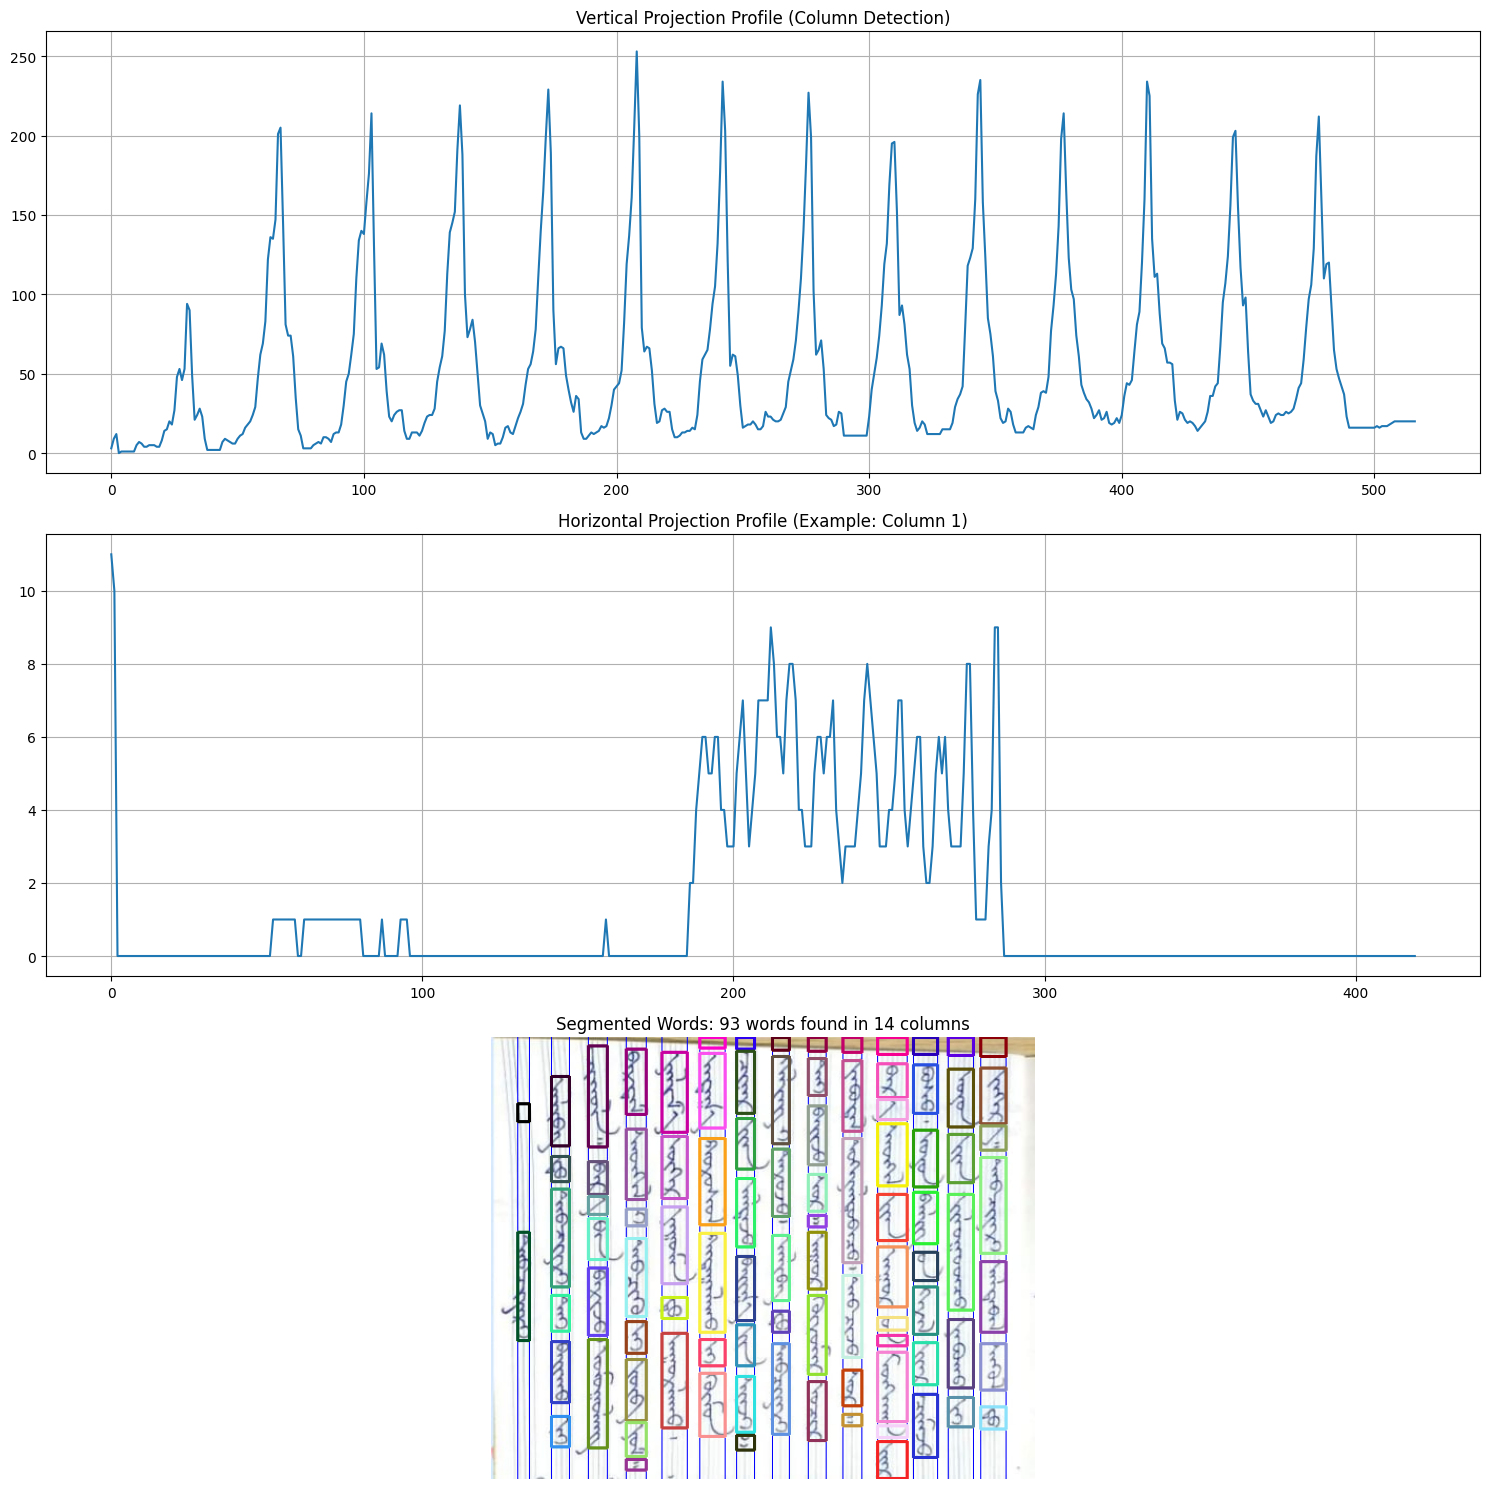

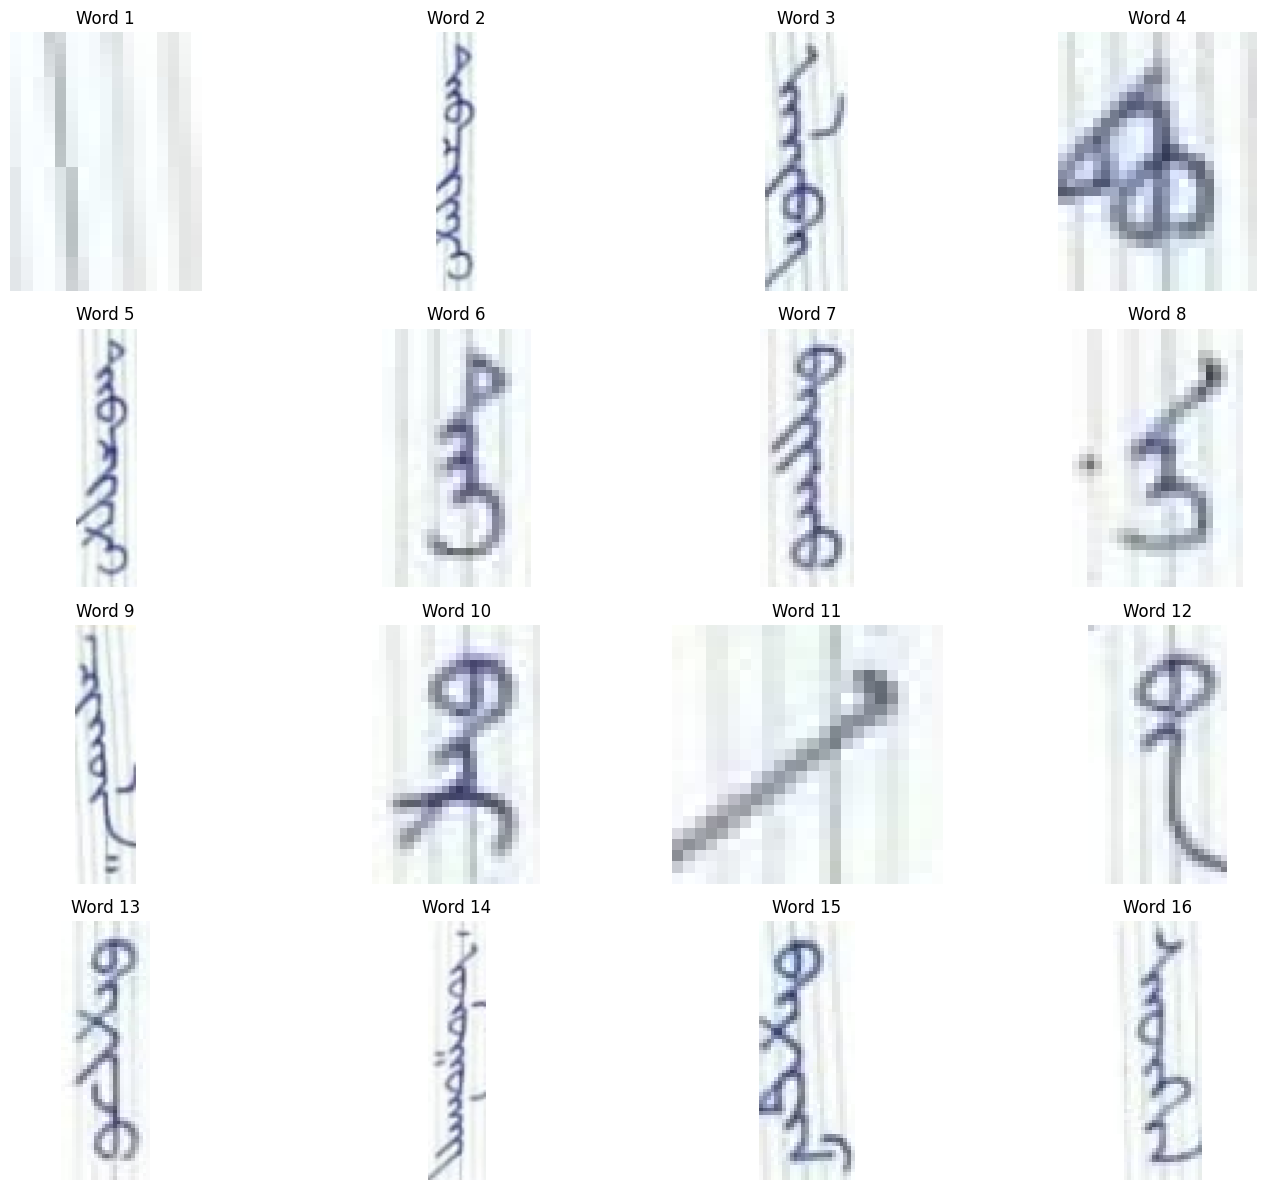

Extracted 93 individual words.


In [145]:
if img is not None and binary_img is not None:
    height, width = binary_img.shape
    print(f"Processing image with dimensions: {width}x{height}")
    
    # Step 1: Detect vertical columns using vertical projection
    vertical_projection = np.sum(binary_img, axis=0) / 255
    
    # Find vertical column separators (large vertical whitespace areas)
    whitespace_threshold = height * 0.06
    is_whitespace = vertical_projection < whitespace_threshold
    
    # Find continuous whitespace regions (column separators)
    column_separators = []
    in_whitespace = False
    whitespace_start = 0
    
    for x in range(width):
        if is_whitespace[x] and not in_whitespace:
            # Start of a whitespace region
            whitespace_start = x
            in_whitespace = True
        elif not is_whitespace[x] and in_whitespace:
            # End of a whitespace region
            whitespace_end = x
            # Only consider whitespace regions wider than threshold
            if whitespace_end - whitespace_start >= 3:
                column_separators.append((whitespace_start, whitespace_end))
            in_whitespace = False
    
    # Handle case where image ends with whitespace
    if in_whitespace and width - whitespace_start >= 3:
        column_separators.append((whitespace_start, width))
    
    print(f"Found {len(column_separators)} column separators")
    
    # Identify column regions based on separators
    column_regions = []
    current_pos = 0
    
    for sep_start, sep_end in column_separators:
        if sep_start > current_pos:
            column_regions.append((current_pos, sep_start))
        current_pos = sep_end
    
    # If last separator doesn't end at image width, we have a column at the end
    if current_pos < width:
        column_regions.append((current_pos, width))
    
    # Filter out regions that are too narrow
    column_regions = [(start, end) for start, end in column_regions if end - start >= MIN_WORD_WIDTH]
    
    print(f"Identified {len(column_regions)} vertical columns")
    
    # Step 2: For each column, segment words horizontally
    all_words = []
    
    for col_idx, (col_start, col_end) in enumerate(column_regions):
        # Extract this column
        column_img = binary_img[:, col_start:col_end]
        
        # Calculate horizontal projection for this column (sum across rows)
        horizontal_projection = np.sum(column_img, axis=1) / 255
        
        # Smooth the projection to reduce noise
        smoothed_h_projection = np.convolve(horizontal_projection, np.ones(5)/5, mode='same')
        
        # Find horizontal whitespace (where horizontal projection is low)
        h_whitespace_threshold = (col_end - col_start) * 0.07  # Adjust threshold based on column width
        h_is_whitespace = smoothed_h_projection < h_whitespace_threshold
        
        # Find word boundaries within this column
        word_boundaries = []
        in_word = False
        word_start = 0
        
        for y in range(height):
            if not h_is_whitespace[y] and not in_word:
                # Start of a word
                word_start = y
                in_word = True
            elif h_is_whitespace[y] and in_word:
                # End of a word
                word_end = y
                # Only consider words taller than threshold
                if word_end - word_start >= 10:  # Minimum word height
                    word_boundaries.append((word_start, word_end))
                in_word = False
        
        # Handle case where column ends with a word
        if in_word and height - word_start >= 10:
            word_boundaries.append((word_start, height))
        
        print(f"Column {col_idx+1}: Found {len(word_boundaries)} words")
        
        # Store words with their position info
        for word_idx, (word_start, word_end) in enumerate(word_boundaries):
            all_words.append({
                'col_idx': col_idx,
                'col_start': col_start,
                'col_end': col_end,
                'word_idx': word_idx,
                'word_start': word_start,
                'word_end': word_end
            })
    
    print(f"Total words found across all columns: {len(all_words)}")
    
    # Visualize the segmentation
    img_with_words = img_rgb.copy()
    
    # Draw column boundaries in blue
    for col_start, col_end in column_regions:
        cv2.line(img_with_words, (col_start, 0), (col_start, height), (0, 0, 255), 1)
        cv2.line(img_with_words, (col_end, 0), (col_end, height), (0, 0, 255), 1)
    
    # Draw word boundaries in different colors
    for word in all_words:
        col_start = word['col_start']
        col_end = word['col_end']
        word_start = word['word_start']
        word_end = word['word_end']
        
        # Generate a unique color for each word
        color = [(word['col_idx']*50)%255, (word['word_idx']*80)%255, ((word['col_idx']+word['word_idx'])*40)%255]
        
        # Draw rectangle around the word
        cv2.rectangle(img_with_words, 
                     (col_start, word_start), 
                     (col_end, word_end), 
                     color, 2)
    
    # Display the projection profiles and segmentation
    plt.figure(figsize=(15, 15))
    
    # Plot the vertical projection profile
    plt.subplot(3, 1, 1)
    plt.plot(vertical_projection)
    plt.title('Vertical Projection Profile (Column Detection)')
    plt.grid(True)
    
    # Plot example of horizontal projection for first column (if exists)
    if column_regions:
        col_start, col_end = column_regions[0]
        column_img = binary_img[:, col_start:col_end]
        horizontal_projection = np.sum(column_img, axis=1) / 255
        
        plt.subplot(3, 1, 2)
        plt.plot(horizontal_projection)
        plt.title(f'Horizontal Projection Profile (Example: Column 1)')
        plt.grid(True)
    
    # Show the image with segmented words
    plt.subplot(3, 1, 3)
    plt.imshow(img_with_words)
    plt.title(f'Segmented Words: {len(all_words)} words found in {len(column_regions)} columns')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Extract and display individual words
    cropped_words = []
    
    for word in all_words:
        # Add padding but prevent out-of-bounds
        pad_col_start = max(0, word['col_start'] - PADDING)
        pad_col_end = min(width, word['col_end'] + PADDING)
        pad_word_start = max(0, word['word_start'] - PADDING)
        pad_word_end = min(height, word['word_end'] + PADDING)
        
        word_img = img_rgb[pad_word_start:pad_word_end, pad_col_start:pad_col_end, :]
        cropped_words.append(word_img)
    
    # Display a sample of words in a grid
    if cropped_words:
        max_words_to_show = min(len(cropped_words), 16)
        rows = int(np.ceil(max_words_to_show / 4))  # 4 columns
        
        plt.figure(figsize=(15, rows * 3))
        for i in range(max_words_to_show):
            plt.subplot(rows, 4, i + 1)
            plt.imshow(cropped_words[i])
            plt.title(f"Word {i+1}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Extracted {len(cropped_words)} individual words.")
else:
    print("Image or binary image not available for word segmentation.")


Extracting 14 word images...
Successfully extracted 14 words.

Displaying first 10 extracted words:


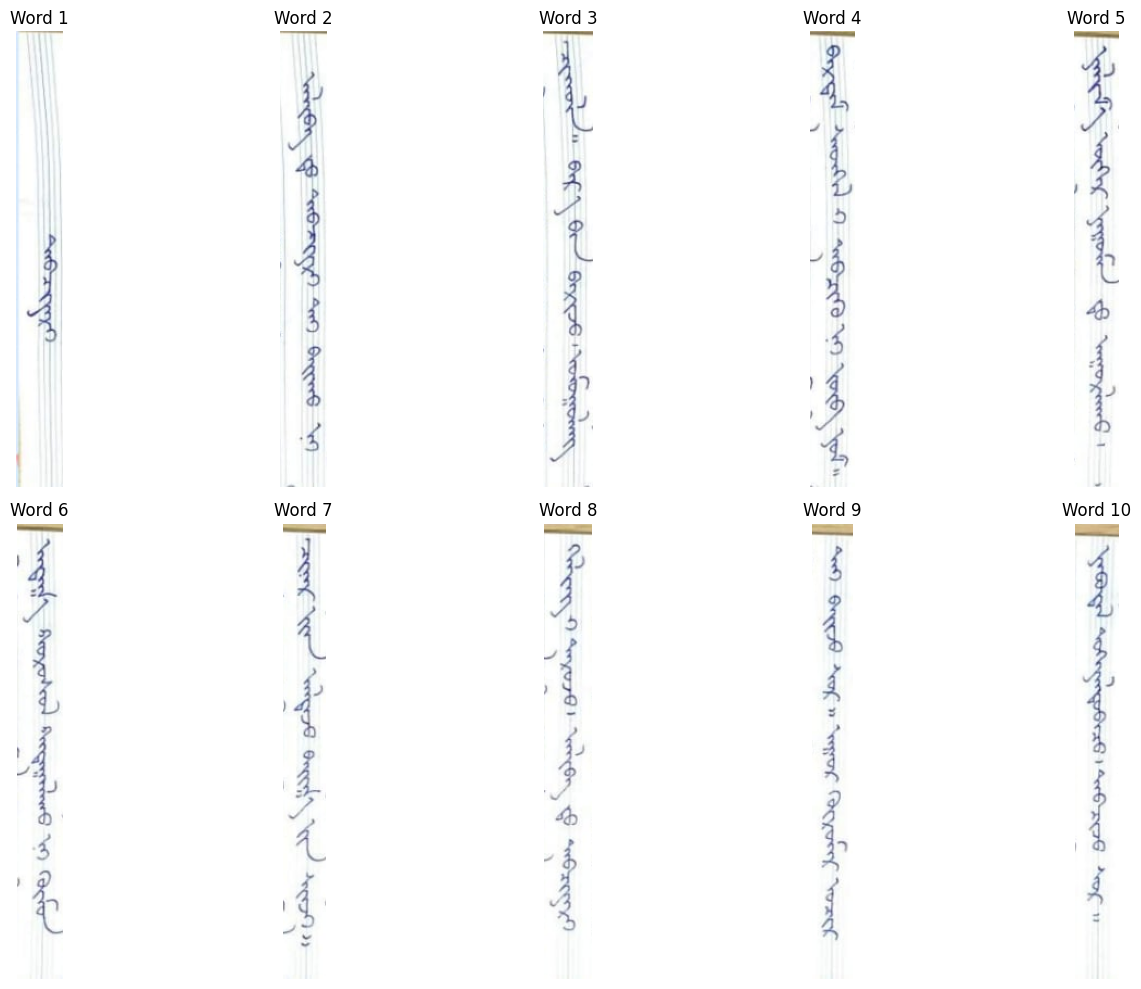

In [6]:
# Reset list for potentially new run
cropped_words_rgb = []

if img is not None and final_boundaries:
    print(f"\nExtracting {len(final_boundaries)} word images...")

    for i, (start_x, end_x) in enumerate(final_boundaries):
        # Calculate crop coordinates with padding
        # Ensure start/end are within image bounds *after* potential valley shifts
        crop_start_x = max(0, start_x - PADDING)
        crop_end_x = min(img.shape[1], end_x + PADDING)

        # Ensure coordinates are valid
        if crop_start_x >= crop_end_x:
             print(f"Skipping invalid crop for boundary {i+1}: start={start_x}, end={end_x} -> crop=({crop_start_x}, {crop_end_x})")
             continue

        # Crop from the original BGR image
        word_img_bgr = img[0:img.shape[0], crop_start_x:crop_end_x]

        # Ensure the crop is valid before adding
        if word_img_bgr.size > 0:
            # Convert to RGB for displaying and store it
            cropped_words_rgb.append(cv2.cvtColor(word_img_bgr, cv2.COLOR_BGR2RGB))
        else:
            print(f"Skipping empty crop for boundary {i+1} ({start_x}, {end_x}) -> crop=({crop_start_x}, {crop_end_x})")

    print(f"Successfully extracted {len(cropped_words_rgb)} words.")

    # Display the first few extracted words using Matplotlib
    num_to_show = min(len(cropped_words_rgb), 10) # Show up to 10 words
    if num_to_show > 0:
        print(f"\nDisplaying first {num_to_show} extracted words:")
        cols = min(num_to_show, 5) # Max 5 columns
        rows = (num_to_show + cols - 1) // cols
        plt.figure(figsize=(cols * 3, rows * 5)) # Adjust size

        for i in range(num_to_show):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(cropped_words_rgb[i])
            plt.title(f'Word {i+1}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    # The 'cropped_words_rgb' list now contains the segmented word images

elif img is not None:
     print("No word boundaries were defined (likely no valleys found or image issue). Cannot extract words.")
else:
    print("Skipping word extraction because image failed to load.")